# Portfolio Asset Clustering Project (Canary Group)

## Dataset Preparation and Feature Engineering

### Import Libraries and Initialize Variables

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from datetime import datetime
import warnings
warnings.filterwarnings('ignore')

# Preprocessing
from sklearn.preprocessing import RobustScaler, PowerTransformer, MinMaxScaler
from sklearn.feature_selection import VarianceThreshold
from sklearn.decomposition import PCA
from sklearn.impute import KNNImputer

# Clustering Algorithms
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN, SpectralClustering, MiniBatchKMeans, Birch   
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage

# Metrics and Validation
from sklearn.metrics import silhouette_score, calinski_harabasz_score, davies_bouldin_score
from scipy.spatial.distance import pdist, squareform
from scipy import stats

# Visualization settings
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['savefig.dpi'] = 300
plt.rcParams['font.size'] = 10

### Load Data

In [195]:
# Load SP500 data for 2Y (2023-2025)
df = pd.read_excel('sp500_stock_data.xlsx', sheet_name='Stock_Data')
df['Date'] = pd.to_datetime(df['Date'])
df = df.sort_values(['Ticker', 'Date'])

print(f"Unique stocks: {df['Ticker'].nunique()}")
print(f"Date range: {df['Date'].min().date()} to {df['Date'].max().date()}")
print(f"Trading days: {df['Date'].nunique()}")

Unique stocks: 500
Date range: 2023-12-04 to 2025-11-28
Trading days: 499


### Feature calculation functions

In [196]:
def calculate_advanced_features(group):
    """Calculate comprehensive features for clustering"""
    features = {}
    
    returns = group['Daily_Return'].dropna()
    prices = group['Close']
    
    if len(returns) < 252:
        return pd.Series(features)
    
    # ===== RETURN METRICS =====
    features['mean_return'] = returns.mean() * 252
    features['volatility'] = returns.std() * np.sqrt(252)
    features['sharpe_ratio'] = (features['mean_return'] / features['volatility']) if features['volatility'] > 0 else 0
    
    # Period returns
    features['return_1m'] = (prices.iloc[-1] / prices.iloc[-21] - 1) if len(prices) >= 21 else 0
    features['return_3m'] = (prices.iloc[-1] / prices.iloc[-63] - 1) if len(prices) >= 63 else 0
    features['return_6m'] = (prices.iloc[-1] / prices.iloc[-126] - 1) if len(prices) >= 126 else 0
    features['return_1y'] = (prices.iloc[-1] / prices.iloc[-252] - 1) if len(prices) >= 252 else 0
    
    # ===== RISK METRICS =====
    # Downside risk
    downside_returns = returns[returns < 0]
    features['downside_dev'] = downside_returns.std() * np.sqrt(252) if len(downside_returns) > 0 else 0
    features['sortino_ratio'] = (features['mean_return'] / features['downside_dev']) if features['downside_dev'] > 0 else 0
    
    # Maximum drawdown
    cumulative = (1 + returns).cumprod()
    running_max = cumulative.expanding().max()
    drawdown = (cumulative - running_max) / running_max
    features['max_drawdown'] = abs(drawdown.min())
    features['calmar_ratio'] = (features['mean_return'] / features['max_drawdown']) if features['max_drawdown'] > 0 else 0
    
    # VaR and CVaR
    features['var_95'] = abs(returns.quantile(0.05))
    features['cvar_95'] = abs(returns[returns <= returns.quantile(0.05)].mean())
    
    # ===== DISTRIBUTION FEATURES =====
    features['skewness'] = returns.skew()
    features['kurtosis'] = returns.kurtosis()
    
    # Tail ratios
    positive_returns = returns[returns > 0]
    negative_returns = returns[returns < 0]
    features['tail_ratio'] = (abs(positive_returns.quantile(0.95)) / abs(negative_returns.quantile(0.05))) if len(negative_returns) > 0 else 1
    
    # Win rate
    features['win_rate'] = (returns > 0).sum() / len(returns)
    
    # ===== MOMENTUM & TREND =====
    # RSI
    delta = prices.diff()
    gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
    loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
    rs = gain / loss
    features['rsi'] = (100 - (100 / (1 + rs))).iloc[-1] if len(rs) > 0 else 50
    
    # Moving average ratios
    sma_50 = prices.rolling(50).mean()
    sma_200 = prices.rolling(200).mean()
    features['price_to_sma50'] = prices.iloc[-1] / sma_50.iloc[-1] if len(sma_50) > 0 else 1
    features['price_to_sma200'] = prices.iloc[-1] / sma_200.iloc[-1] if len(sma_200) > 0 else 1
    features['sma50_to_sma200'] = sma_50.iloc[-1] / sma_200.iloc[-1] if len(sma_200) > 0 else 1
    
    # ===== VOLATILITY DYNAMICS =====
    # Rolling volatility
    vol_20 = returns.rolling(20).std() * np.sqrt(252)
    vol_60 = returns.rolling(60).std() * np.sqrt(252)
    features['vol_20d'] = vol_20.iloc[-1] if len(vol_20) > 0 else 0
    features['vol_60d'] = vol_60.iloc[-1] if len(vol_60) > 0 else 0
    features['vol_ratio'] = features['vol_20d'] / features['vol_60d'] if features['vol_60d'] > 0 else 1
    
    # ===== AUTOCORRELATION =====
    features['autocorr_1'] = returns.autocorr(lag=1) if len(returns) > 1 else 0
    features['autocorr_5'] = returns.autocorr(lag=5) if len(returns) > 5 else 0
    
    # ===== LIQUIDITY METRICS =====
    if 'Volume' in group.columns:
        volume = group['Volume']
        features['avg_volume'] = volume.mean()
        features['volume_volatility'] = volume.std() / volume.mean() if volume.mean() > 0 else 0
        
        # Dollar volume
        dollar_volume = prices * volume
        features['avg_dollar_volume'] = dollar_volume.mean()
        
        # Amihud illiquidity
        illiquidity = (abs(returns) / dollar_volume).replace([np.inf, -np.inf], np.nan).dropna()
        features['amihud_illiquidity'] = illiquidity.mean() * 1e6 if len(illiquidity) > 0 else 0
    
    return pd.Series(features)

# Calculate features for each stock
stock_features = df.groupby('Ticker').apply(calculate_advanced_features)
stock_features = stock_features.dropna(how='all')

# Add categorical features
if 'company' in df.columns:
    companies = df.groupby('Ticker')['company'].first()
    stock_features = stock_features.join(companies)

if 'sector' in df.columns:
    sectors = df.groupby('Ticker')['sector'].first()
    stock_features = stock_features.join(sectors)

if 'industry' in df.columns:
    industries = df.groupby('Ticker')['industry'].first()
    stock_features = stock_features.join(industries)

print(f"\nFeatures calculated for {len(stock_features)} stocks")
print(f"Total features: {stock_features.select_dtypes(include=[np.number]).shape[1]}")
stock_features.to_excel('sp500_latest_features.xlsx', index=True)
stock_features.to_csv('sp500_latest_features.csv', index=True)


Features calculated for 500 stocks
Total features: 30


In [197]:
print(f"\n{'='*60}")
print("SUMMARY STATISTICS")
print(f"{'='*60}")

# Show feature summary
print("\nFeatures by category:")
print(f"  Returns: {len([c for c in stock_features.columns if 'return' in c.lower()])}")
print(f"  Risk: {len([c for c in stock_features.columns if 'var' in c.lower() or 'vol' in c.lower() or 'drawdown' in c.lower() or 'sharpe' in c.lower()])}")
print(f"  Technical: {len([c for c in stock_features.columns if any(x in c.lower() for x in ['sma', 'ema', 'rsi', 'macd'])])}")
print(f"  Statistical: {len([c for c in stock_features.columns if any(x in c.lower() for x in ['skew', 'kurt', 'autocorr'])])}")
print(f"  Liquidity: {len([c for c in stock_features.columns if 'volume' in c.lower() or 'liquidity' in c.lower()])}")
print(f"  Tail Risk: {len([c for c in stock_features.columns if any(x in c.lower() for x in ['tail', 'shortfall', 'gain_to_pain', 'win_rate'])])}")


SUMMARY STATISTICS

Features by category:
  Returns: 5
  Risk: 11
  Technical: 4
  Statistical: 4
  Liquidity: 4
  Tail Risk: 2


### LOAD AND EXPLORE DATA

In [198]:
print(f"\nDataset Shape: {stock_features.shape}")

# Separate numerical and categorical features
numerical_features = stock_features.select_dtypes(include=[np.number])
categorical_features = stock_features.select_dtypes(exclude=[np.number])


print(f"\nNumerical features: {len(numerical_features.columns)}")
print(f"Categorical features: {len(categorical_features.columns)}")

# Check for missing values
missing_vals = stock_features.isnull().sum()
missing_per = ((stock_features.isnull().sum() / len(stock_features)) * 100).round(2)
missing_df = pd.DataFrame({'Missing Count': missing_vals,'Percentage (%)': missing_per}) # Combine into a DataFrame for better visualization
missing_df[missing_df['Missing Count'] > 0].sort_values(by='Missing Count', ascending=False)


Dataset Shape: (500, 33)

Numerical features: 30
Categorical features: 3


,Missing Count,Percentage (%)


## Feature Engineering and Dimensionality Reduction

### Feature Preprocessing and Scaling

In [ ]:
print(f"\n{'='*80}")
print("PREPROCESSING PIPELINE")
print(f"{'='*80}\n")

features_processed = numerical_features.copy()
preprocessing_stats = {'original_features': features_processed.shape[1]}

# STEP 1: Handle Missing Values
missing_count = features_processed.isnull().sum().sum()
if missing_count > 0:
    print(f"[1] Imputing {missing_count} missing values using KNN (k=5)...")
    imputer = KNNImputer(n_neighbors=5, weights='distance')
    features_processed = pd.DataFrame(
        imputer.fit_transform(features_processed),
        index=features_processed.index,
        columns=features_processed.columns
    )
else:
    print("[1] No missing values found")

# STEP 2: Handle Infinite Values
inf_count = np.isinf(features_processed).sum().sum()
if inf_count > 0:
    print(f"[2] Handling {inf_count} infinite values...")
    features_processed = features_processed.replace([np.inf, -np.inf], np.nan)
    features_processed = features_processed.fillna(features_processed.median())
else:
    print("[2] No infinite values found")

# STEP 3: Remove Low-Variance Features
print("[3] Removing low-variance features...")
temp_scaler = MinMaxScaler()
temp_scaled = pd.DataFrame(temp_scaler.fit_transform(features_processed), columns=features_processed.columns)
selector = VarianceThreshold(threshold=0.01)
selector.fit(temp_scaled)
low_var_features = features_processed.columns[~selector.get_support()]
features_processed = features_processed.loc[:, selector.get_support()]
preprocessing_stats['low_variance_removed'] = len(low_var_features)
print(f"    Removed {len(low_var_features)} low-variance features")

# STEP 4: Remove Highly Correlated Features
print("[4] Removing highly correlated features (correlation > 0.95)...")
corr_matrix = features_processed.corr().abs()
upper_triangle = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))
to_drop = [col for col in upper_triangle.columns if any(upper_triangle[col] > 0.95)]
features_processed = features_processed.drop(columns=to_drop)
preprocessing_stats['correlation_removed'] = len(to_drop)
print(f"    Removed {len(to_drop)} highly correlated features")

# STEP 5: Winsorize Outliers
print("[5] Winsorizing outliers at 1st and 99th percentiles...")
outliers_clipped = 0
for col in features_processed.columns:
    lower = features_processed[col].quantile(0.01)
    upper = features_processed[col].quantile(0.99)
    before = ((features_processed[col] < lower) | (features_processed[col] > upper)).sum()
    features_processed[col] = features_processed[col].clip(lower=lower, upper=upper)
    outliers_clipped += before
preprocessing_stats['outliers_clipped'] = outliers_clipped
print(f"    Clipped {outliers_clipped} outlier values")

# STEP 6: Transform Skewed Features
print("[6] Transforming skewed distributions (|skew| > 1)...")
skewness = features_processed.skew().abs()
skewed_features = skewness[skewness > 1].index.tolist()
if len(skewed_features) > 0:
    pt = PowerTransformer(method='yeo-johnson', standardize=False)
    features_processed[skewed_features] = pt.fit_transform(features_processed[skewed_features])
preprocessing_stats['skewed_transformed'] = len(skewed_features)
print(f"    Transformed {len(skewed_features)} skewed features")

# STEP 7: Robust Scaling
print("[7] Applying RobustScaler...")
scaler = RobustScaler()
features_scaled = pd.DataFrame(
    scaler.fit_transform(features_processed),
    index=features_processed.index,
    columns=features_processed.columns
)
preprocessing_stats['final_features'] = features_scaled.shape[1]

print(f"\n{'='*80}")
print("PREPROCESSING SUMMARY")
print(f"{'='*80}")
print(f"Original features:        {preprocessing_stats['original_features']}")
print(f"Low-variance removed:     {preprocessing_stats['low_variance_removed']}")
print(f"Correlation removed:      {preprocessing_stats['correlation_removed']}")
print(f"Outliers winsorized:      {preprocessing_stats['outliers_clipped']}")
print(f"Skewed transformed:       {preprocessing_stats['skewed_transformed']}")
print(f"Final features:           {preprocessing_stats['final_features']}")
print(f"Stocks in analysis:       {len(features_scaled)}")

features_scaled.to_csv('02_features_preprocessed.csv')


PREPROCESSING PIPELINE

[1] No missing values found
[2] No infinite values found
[3] Removing low-variance features...
    Removed 5 low-variance features
[4] Removing highly correlated features (correlation > 0.95)...
    Removed 3 highly correlated features
[5] Winsorizing outliers at 1st and 99th percentiles...
    Clipped 220 outlier values
[7] Applying RobustScaler...

PREPROCESSING SUMMARY
Original features:        31
Low-variance removed:     5
Correlation removed:      3
Outliers winsorized:      220
Final features:           23
Stocks in analysis:       500


### PCA for Dimensionality Reduction

In [225]:
print(f"\n{'='*80}")
print("PCA DIMENSIONALITY REDUCTION")
print(f"{'='*80}\n")

# Apply PCA retaining 95% variance
pca = PCA(n_components=0.95)
features_pca = pca.fit_transform(features_scaled)

print(f"Original features:     {features_scaled.shape[1]}")
print(f"PCA components:        {features_pca.shape[1]}")
print(f"Variance explained:    {pca.explained_variance_ratio_.sum():.2%}")
print(f"Dimensionality reduction: {(1 - features_pca.shape[1]/features_scaled.shape[1])*100:.1f}%")

print(f"\nTop 5 Principal Components:")
cumsum = 0
for i in range(min(5, len(pca.explained_variance_ratio_))):
    cumsum += pca.explained_variance_ratio_[i]
    print(f"  PC{i+1}: {pca.explained_variance_ratio_[i]*100:5.2f}% (Cumulative: {cumsum*100:5.2f}%)")

features_pca_df = pd.DataFrame(
    features_pca,
    index=features_scaled.index,
    columns=[f'PC{i+1}' for i in range(features_pca.shape[1])]
)

features_pca_df.to_csv('03_features_pca.csv')


PCA DIMENSIONALITY REDUCTION

Original features:     23
PCA components:        12
Variance explained:    95.77%
Dimensionality reduction: 47.8%

Top 5 Principal Components:
  PC1: 30.66% (Cumulative: 30.66%)
  PC2: 24.23% (Cumulative: 54.88%)
  PC3: 11.92% (Cumulative: 66.80%)
  PC4:  6.15% (Cumulative: 72.95%)
  PC5:  4.63% (Cumulative: 77.58%)


### Optimal Number of Clusters


OPTIMAL NUMBER OF CLUSTERS

Testing K-Means with different cluster numbers...
Using 3 validation metrics for robust selection:

Metrics by number of clusters:

k    Silhouette   Calinski-H   Davies-B    
------------------------------------------------
3    0.2092       129.47       1.5765       ← OPTIMAL
4    0.1964       115.02       1.5912      
5    0.1775       106.20       1.6191      
6    0.1691       96.56        1.5957      
7    0.1671       89.79        1.5536      
8    0.1398       83.71        1.5925      
9    0.1301       79.24        1.7024      
10   0.1289       73.96        1.7187      

Based on Silhouette Score (higher=better): k = 3
Based on Calinski-Harabasz (higher=better): k = 3
Based on Davies-Bouldin (lower=better): k = 7

✓ SELECTED: k = 3 clusters (based on Silhouette)


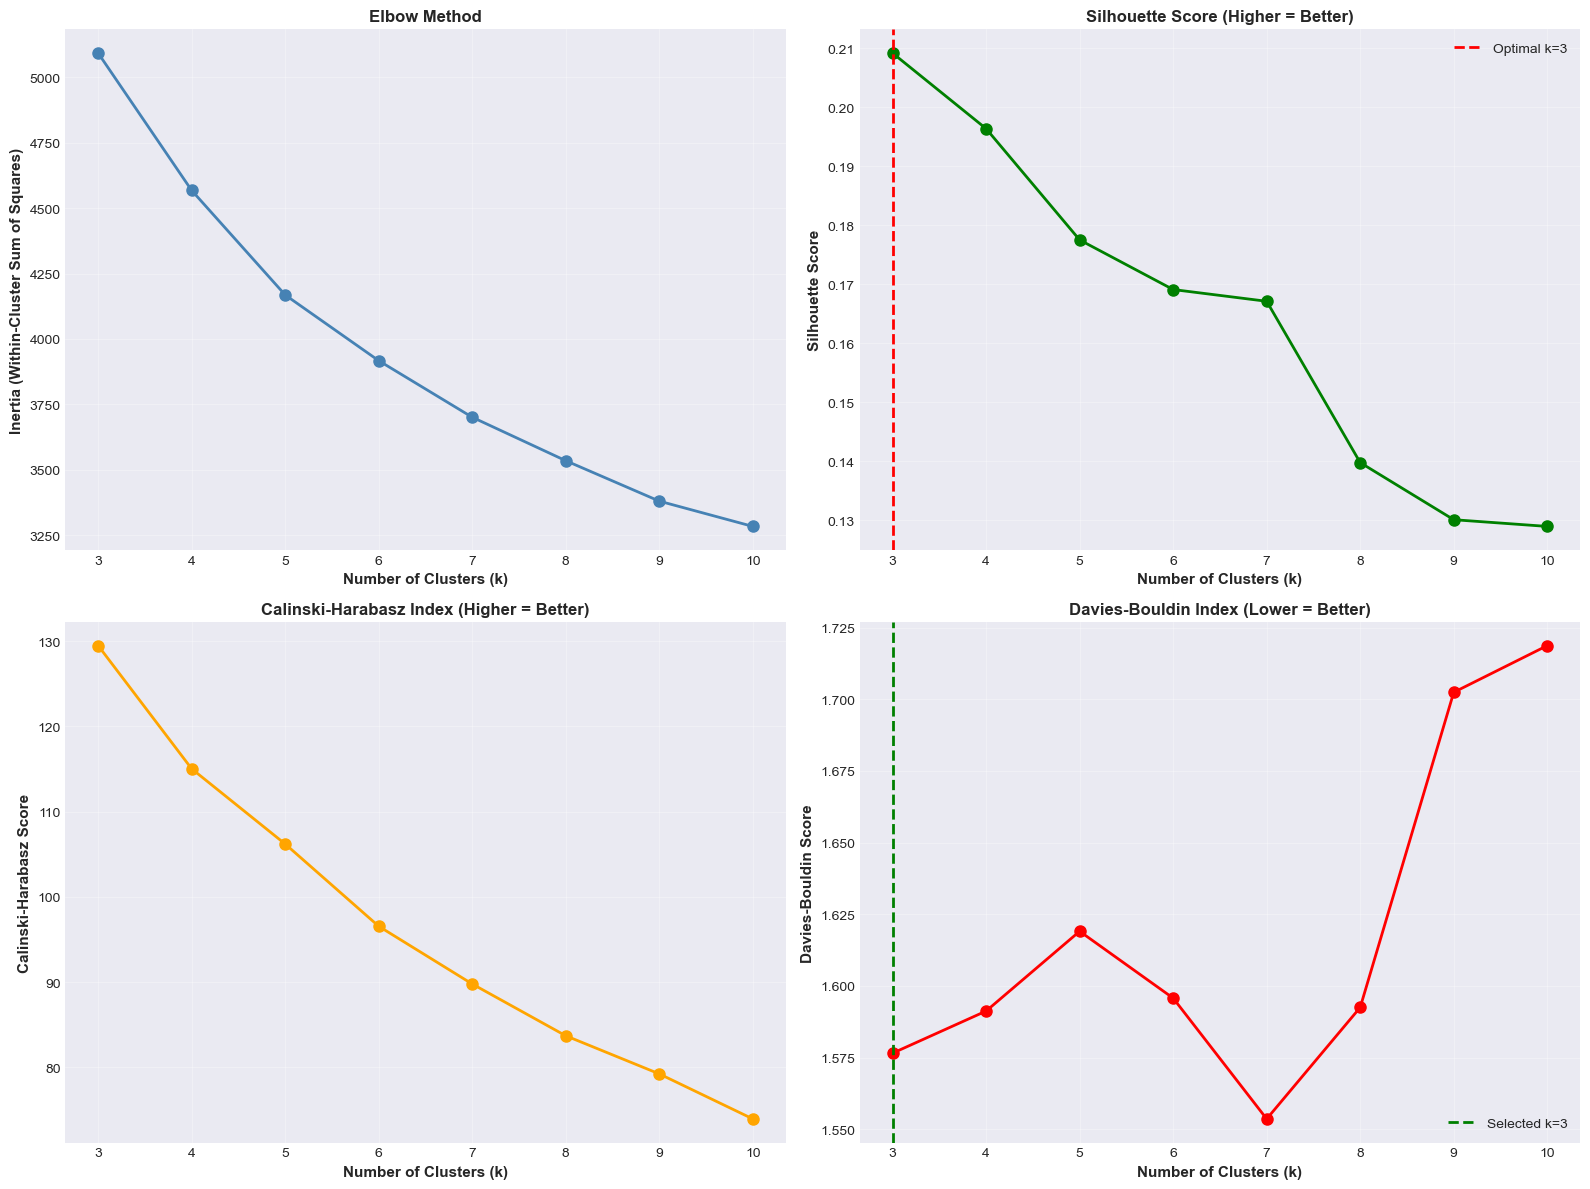

In [226]:
print(f"\n{'='*80}")
print("OPTIMAL NUMBER OF CLUSTERS")
print(f"{'='*80}")

print("\nTesting K-Means with different cluster numbers...")
print("Using 3 validation metrics for robust selection:\n")

# Test range of k values
k_range = range(3, 11)
inertias = []
silhouette_scores = []
calinski_scores = []
davies_bouldin_scores = []

for k in k_range:
    kmeans = KMeans(n_clusters=k, random_state=42, n_init=20)
    labels = kmeans.fit_predict(features_pca)
    
    inertias.append(kmeans.inertia_)
    silhouette_scores.append(silhouette_score(features_pca, labels))
    calinski_scores.append(calinski_harabasz_score(features_pca, labels))
    davies_bouldin_scores.append(davies_bouldin_score(features_pca, labels))

# Find optimal k based on different metrics
optimal_k_silhouette = k_range[np.argmax(silhouette_scores)]
optimal_k_calinski = k_range[np.argmax(calinski_scores)]
optimal_k_davies = k_range[np.argmin(davies_bouldin_scores)]

print("Metrics by number of clusters:\n")
print(f"{'k':<4} {'Silhouette':<12} {'Calinski-H':<12} {'Davies-B':<12}")
print("-" * 48)
for i, k in enumerate(k_range):
    marker = " ← OPTIMAL" if k == optimal_k_silhouette else ""
    print(f"{k:<4} {silhouette_scores[i]:<12.4f} {calinski_scores[i]:<12.2f} {davies_bouldin_scores[i]:<12.4f}{marker}")

print(f"\n{'='*80}")
print(f"Based on Silhouette Score (higher=better): k = {optimal_k_silhouette}")
print(f"Based on Calinski-Harabasz (higher=better): k = {optimal_k_calinski}")
print(f"Based on Davies-Bouldin (lower=better): k = {optimal_k_davies}")

# Use silhouette for final choice (most commonly used)
optimal_k = optimal_k_silhouette
print(f"\n✓ SELECTED: k = {optimal_k} clusters (based on Silhouette)")

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(16, 12))

# Elbow plot
axes[0, 0].plot(k_range, inertias, 'o-', linewidth=2, markersize=8, color='steelblue')
axes[0, 0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 0].set_ylabel('Inertia (Within-Cluster Sum of Squares)', fontsize=11, fontweight='bold')
axes[0, 0].set_title('Elbow Method', fontsize=12, fontweight='bold')
axes[0, 0].grid(True, alpha=0.3)
axes[0, 0].set_xticks(k_range)

# Silhouette scores
axes[0, 1].plot(k_range, silhouette_scores, 'o-', linewidth=2, markersize=8, color='green')
axes[0, 1].axvline(x=optimal_k, color='r', linestyle='--', linewidth=2, label=f'Optimal k={optimal_k}')
axes[0, 1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[0, 1].set_ylabel('Silhouette Score', fontsize=11, fontweight='bold')
axes[0, 1].set_title('Silhouette Score (Higher = Better)', fontsize=12, fontweight='bold')
axes[0, 1].legend(loc='best', fontsize=10)
axes[0, 1].grid(True, alpha=0.3)
axes[0, 1].set_xticks(k_range)

# Calinski-Harabasz
axes[1, 0].plot(k_range, calinski_scores, 'o-', linewidth=2, markersize=8, color='orange')
axes[1, 0].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 0].set_ylabel('Calinski-Harabasz Score', fontsize=11, fontweight='bold')
axes[1, 0].set_title('Calinski-Harabasz Index (Higher = Better)', fontsize=12, fontweight='bold')
axes[1, 0].grid(True, alpha=0.3)
axes[1, 0].set_xticks(k_range)

# Davies-Bouldin
axes[1, 1].plot(k_range, davies_bouldin_scores, 'o-', linewidth=2, markersize=8, color='red')
axes[1, 1].axvline(x=optimal_k, color='g', linestyle='--', linewidth=2, label=f'Selected k={optimal_k}')
axes[1, 1].set_xlabel('Number of Clusters (k)', fontsize=11, fontweight='bold')
axes[1, 1].set_ylabel('Davies-Bouldin Score', fontsize=11, fontweight='bold')
axes[1, 1].set_title('Davies-Bouldin Index (Lower = Better)', fontsize=12, fontweight='bold')
axes[1, 1].legend(loc='best', fontsize=10)
axes[1, 1].grid(True, alpha=0.3)
axes[1, 1].set_xticks(k_range)

plt.tight_layout()
plt.savefig('04_optimal_clusters.png', dpi=300, bbox_inches='tight')
plt.show()

### Compare Clustering Algorithms

In [227]:
print(f"\n{'='*80}")
print("CLUSTERING ALGORITHM COMPARISON")
print(f"{'='*80}\n")

clustering_results = {}

# Define algorithms to test
algorithms = {
    'K-Means': KMeans(n_clusters=optimal_k, random_state=42, n_init=20),
    'Mini-Batch K-Means': MiniBatchKMeans(n_clusters=optimal_k, random_state=42, n_init=20),
    'Hierarchical (Ward)': AgglomerativeClustering(n_clusters=optimal_k, linkage='ward'),
    'Hierarchical (Complete)': AgglomerativeClustering(n_clusters=optimal_k, linkage='complete'),
    'Hierarchical (Average)': AgglomerativeClustering(n_clusters=optimal_k, linkage='average'),
    'Gaussian Mixture': GaussianMixture(n_components=optimal_k, random_state=42, n_init=10),
    'Spectral Clustering': SpectralClustering(n_clusters=optimal_k, random_state=42, affinity='nearest_neighbors'),
    'Birch': Birch(n_clusters=optimal_k)
}

print(f"Testing {len(algorithms)} clustering algorithms...\n")

for name, model in algorithms.items():
    try:
        labels = model.fit_predict(features_pca)
        
        # Calculate metrics
        sil_score = silhouette_score(features_pca, labels)
        cal_score = calinski_harabasz_score(features_pca, labels)
        db_score = davies_bouldin_score(features_pca, labels)
        
        clustering_results[name] = {
            'labels': labels,
            'silhouette': sil_score,
            'calinski': cal_score,
            'davies_bouldin': db_score,
            'n_clusters': len(np.unique(labels))
        }
        
    except Exception as e:
        print(f"⚠ {name} failed: {str(e)[:50]}")
        continue

# Create comparison table
comparison_df = pd.DataFrame({
    'Algorithm': list(clustering_results.keys()),
    'Silhouette': [v['silhouette'] for v in clustering_results.values()],
    'Calinski-Harabasz': [v['calinski'] for v in clustering_results.values()],
    'Davies-Bouldin': [v['davies_bouldin'] for v in clustering_results.values()],
    'Clusters': [v['n_clusters'] for v in clustering_results.values()]
}).sort_values('Silhouette', ascending=False)

print("\nALGORITHM PERFORMANCE COMPARISON")
print("=" * 110)
print(f"{'Algorithm':<25} {'Silhouette':<15} {'Calinski-H':<15} {'Davies-B':<15} {'Clusters':<10}")
print("=" * 110)
for idx, row in comparison_df.iterrows():
    marker = " ← BEST" if idx == comparison_df.index[0] else ""
    print(f"{row['Algorithm']:<25} {row['Silhouette']:<15.4f} {row['Calinski-Harabasz']:<15.2f} {row['Davies-Bouldin']:<15.4f} {row['Clusters']:<10}{marker}")

# Select best algorithm
best_algorithm = comparison_df.iloc[0]['Algorithm']
best_labels = clustering_results[best_algorithm]['labels']

print(f"\n✓ Best algorithm: {best_algorithm}")
print(f"  Silhouette Score: {clustering_results[best_algorithm]['silhouette']:.4f}")

# Add labels to dataframes
numerical_features['Cluster'] = best_labels
features_pca_df['Cluster'] = best_labels

# Cluster distribution
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
print(f"\nCluster Distribution:")
for cluster, count in cluster_counts.items():
    print(f"  Cluster {cluster}: {count:3d} stocks ({count/len(best_labels)*100:5.1f}%)")


CLUSTERING ALGORITHM COMPARISON

Testing 8 clustering algorithms...


ALGORITHM PERFORMANCE COMPARISON
Algorithm                 Silhouette      Calinski-H      Davies-B        Clusters  
Hierarchical (Average)    0.3341          58.87           1.3262          3          ← BEST
K-Means                   0.2092          129.47          1.5765          3         
Gaussian Mixture          0.1843          128.65          1.5847          3         
Mini-Batch K-Means        0.1840          128.77          1.5867          3         
Spectral Clustering       0.1816          125.36          1.6004          3         
Birch                     0.1734          120.28          1.6504          3         
Hierarchical (Ward)       0.1645          117.95          1.6681          3         
Hierarchical (Complete)   0.1343          85.64           1.9222          3         

✓ Best algorithm: Hierarchical (Average)
  Silhouette Score: 0.3341

Cluster Distribution:
  Cluster 0:  40 stocks (  8.0%)

In [228]:
print("\n" + "=" * 80)
print("CLUSTERING ALGORITHM COMPARISON")
print("=" * 80)

# Store results
clustering_results = {}

# 1. K-Means
print("\n[1] K-Means Clustering")
kmeans = KMeans(n_clusters=optimal_k, random_state=42, n_init=20)
labels_kmeans = kmeans.fit_predict(features_pca)
clustering_results['K-Means'] = {
    'labels': labels_kmeans,
    'silhouette': silhouette_score(features_pca, labels_kmeans),
    'calinski': calinski_harabasz_score(features_pca, labels_kmeans),
    'davies_bouldin': davies_bouldin_score(features_pca, labels_kmeans)
}
print(f"   Silhouette: {clustering_results['K-Means']['silhouette']:.4f}")
print(f"   Calinski-Harabasz: {clustering_results['K-Means']['calinski']:.2f}")
print(f"   Davies-Bouldin: {clustering_results['K-Means']['davies_bouldin']:.4f}")

# 2. Hierarchical (Ward)
print("\n[2] Hierarchical Clustering (Ward)")
hierarchical = AgglomerativeClustering(n_clusters=optimal_k, linkage='ward')
labels_hierarchical = hierarchical.fit_predict(features_pca)
clustering_results['Hierarchical'] = {
    'labels': labels_hierarchical,
    'silhouette': silhouette_score(features_pca, labels_hierarchical),
    'calinski': calinski_harabasz_score(features_pca, labels_hierarchical),
    'davies_bouldin': davies_bouldin_score(features_pca, labels_hierarchical)
}
print(f"   Silhouette: {clustering_results['Hierarchical']['silhouette']:.4f}")
print(f"   Calinski-Harabasz: {clustering_results['Hierarchical']['calinski']:.2f}")
print(f"   Davies-Bouldin: {clustering_results['Hierarchical']['davies_bouldin']:.4f}")

# 3. Gaussian Mixture Model
print("\n[3] Gaussian Mixture Model")
gmm = GaussianMixture(n_components=optimal_k, random_state=42, n_init=10)
labels_gmm = gmm.fit_predict(features_pca)
clustering_results['GMM'] = {
    'labels': labels_gmm,
    'silhouette': silhouette_score(features_pca, labels_gmm),
    'calinski': calinski_harabasz_score(features_pca, labels_gmm),
    'davies_bouldin': davies_bouldin_score(features_pca, labels_gmm)
}
print(f"   Silhouette: {clustering_results['GMM']['silhouette']:.4f}")
print(f"   Calinski-Harabasz: {clustering_results['GMM']['calinski']:.2f}")
print(f"   Davies-Bouldin: {clustering_results['GMM']['davies_bouldin']:.4f}")

# Select best algorithm
best_algorithm = max(clustering_results.items(), key=lambda x: x[1]['silhouette'])[0]
best_labels = clustering_results[best_algorithm]['labels']

print("\n" + "=" * 80)
print("ALGORITHM COMPARISON SUMMARY")
print("=" * 80)
comparison_df = pd.DataFrame({
    'Algorithm': list(clustering_results.keys()),
    'Silhouette': [v['silhouette'] for v in clustering_results.values()],
    'Calinski-Harabasz': [v['calinski'] for v in clustering_results.values()],
    'Davies-Bouldin': [v['davies_bouldin'] for v in clustering_results.values()]
}).sort_values('Silhouette', ascending=False)
print(comparison_df.to_string(index=False))

print(f"\n✓ BEST ALGORITHM: {best_algorithm}")
print(f"   Silhouette Score: {clustering_results[best_algorithm]['silhouette']:.4f}")

# Add cluster labels to features
numerical_features['Cluster'] = best_labels
features_pca_df['Cluster'] = best_labels

# Cluster distribution
print("\nCluster Distribution:")
cluster_counts = pd.Series(best_labels).value_counts().sort_index()
for cluster, count in cluster_counts.items():
    pct = count / len(best_labels) * 100
    print(f"   Cluster {cluster}: {count} stocks ({pct:.1f}%)")


CLUSTERING ALGORITHM COMPARISON

[1] K-Means Clustering
   Silhouette: 0.2092
   Calinski-Harabasz: 129.47
   Davies-Bouldin: 1.5765

[2] Hierarchical Clustering (Ward)
   Silhouette: 0.1645
   Calinski-Harabasz: 117.95
   Davies-Bouldin: 1.6681

[3] Gaussian Mixture Model
   Silhouette: 0.1843
   Calinski-Harabasz: 128.65
   Davies-Bouldin: 1.5847

ALGORITHM COMPARISON SUMMARY
   Algorithm  Silhouette  Calinski-Harabasz  Davies-Bouldin
     K-Means    0.209157         129.466207        1.576550
         GMM    0.184343         128.652429        1.584721
Hierarchical    0.164456         117.954363        1.668073

✓ BEST ALGORITHM: K-Means
   Silhouette Score: 0.2092

Cluster Distribution:
   Cluster 0: 134 stocks (26.8%)
   Cluster 1: 118 stocks (23.6%)
   Cluster 2: 248 stocks (49.6%)


### Post Clustering Analysis

PCA VISUALIZATION - K-Means

PCA Variance Explained:
  PC1: 66.86%
  PC2: 9.39%
  PC3: 7.44%
  Total (3 components): 83.69%


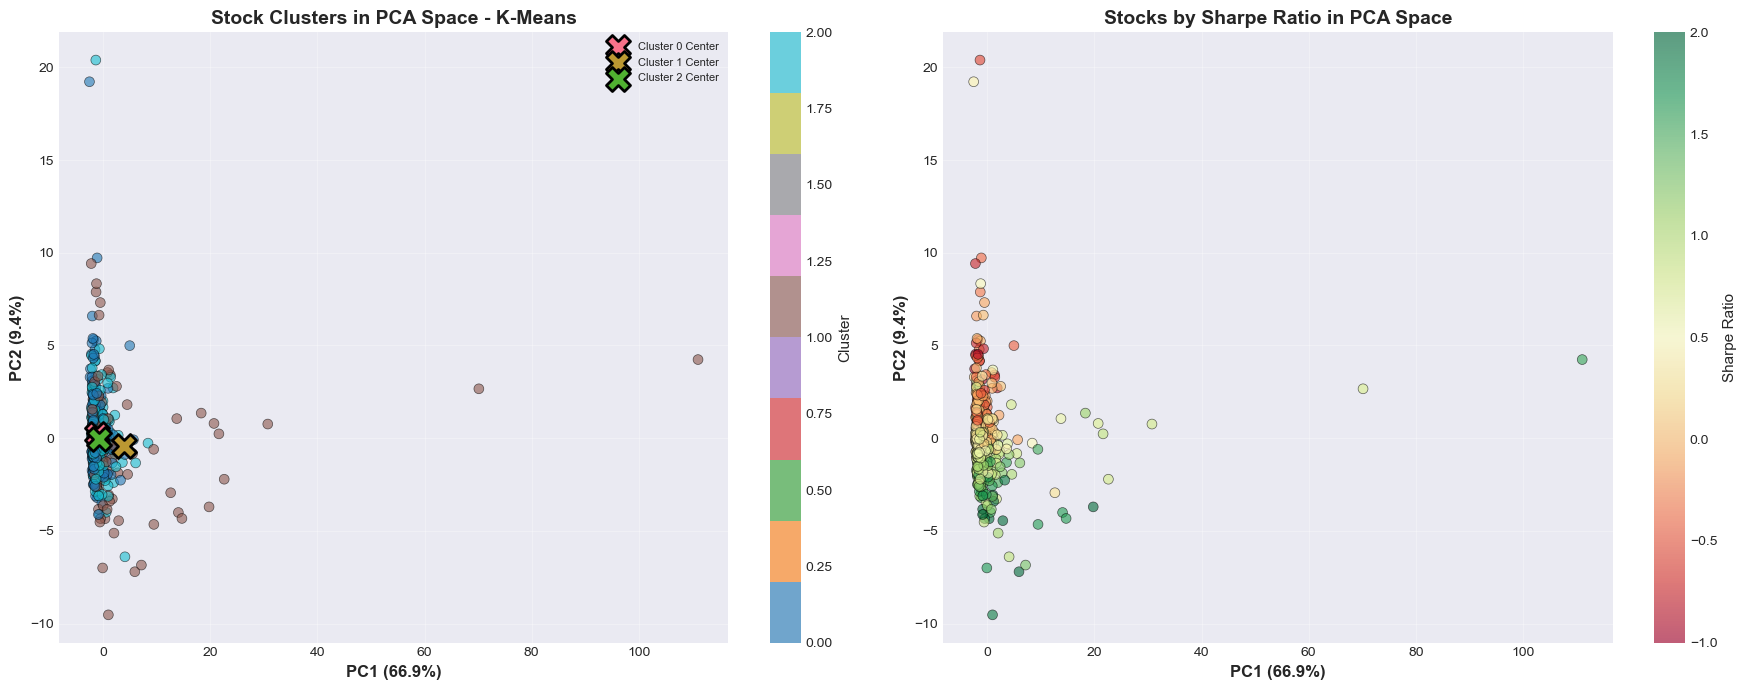


✓ 2D PCA visualization saved


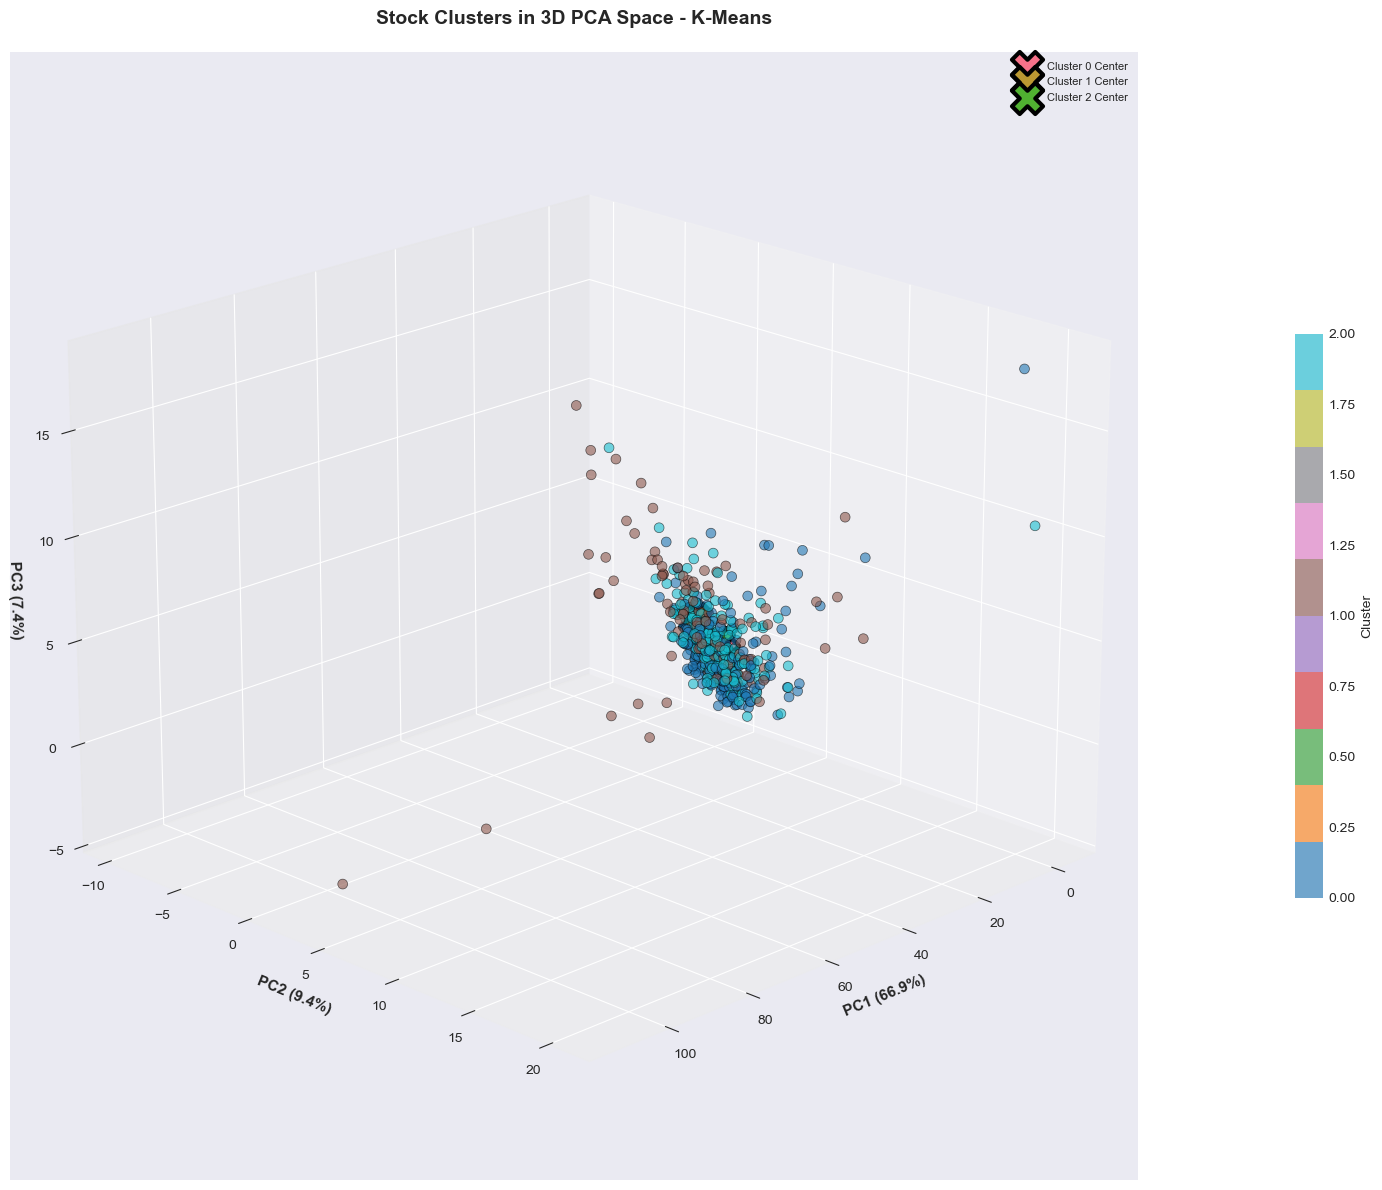

✓ 3D PCA visualization saved

CLUSTER SEPARATION IN PCA SPACE

Centroid Distances (Euclidean):
  Cluster 0 ↔ Cluster 1: 5.408
  Cluster 0 ↔ Cluster 2: 0.616
  Cluster 1 ↔ Cluster 2: 4.935

Within-Cluster Compactness (average distance to centroid):
Cluster 0: 2.641 (tighter is better)
Cluster 1: 8.242 (tighter is better)
Cluster 2: 2.367 (tighter is better)


In [229]:
print(f"PCA VISUALIZATION - {best_algorithm}")
print("="*60)

# Perform PCA for visualization
pca_viz = PCA(n_components=3)
features_pca_viz = pca_viz.fit_transform(features_for_clustering)

print(f"\nPCA Variance Explained:")
for i, var_ratio in enumerate(pca_viz.explained_variance_ratio_, 1):
    print(f"  PC{i}: {var_ratio*100:.2f}%")
print(f"  Total (3 components): {pca_viz.explained_variance_ratio_.sum()*100:.2f}%")

# Filter out noise if present (DBSCAN)
if -1 in final_labels:
    viz_mask = final_labels != -1
    features_pca_viz_clean = features_pca_viz[viz_mask]
    labels_clean = final_labels[viz_mask]
    print(f"\n✓ Filtered out {(~viz_mask).sum()} noise points for visualization")
else:
    features_pca_viz_clean = features_pca_viz
    labels_clean = final_labels

# ══════════════════════════════════════════════════════════════════════════
# 2D PCA VISUALIZATIONS
# ══════════════════════════════════════════════════════════════════════════

fig, axes = plt.subplots(1, 2, figsize=(18, 7))

# Plot 1: Colored by Cluster
ax = axes[0]
scatter = ax.scatter(features_pca_viz_clean[:, 0], features_pca_viz_clean[:, 1], 
                     c=labels_clean, cmap='tab10', s=50, alpha=0.6, 
                     edgecolors='black', linewidth=0.5)

ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12, fontweight='bold')
ax.set_title(f'Stock Clusters in PCA Space - {best_algorithm}', fontsize=14, fontweight='bold')
ax.grid(True, alpha=0.3)

# Add cluster centroids
for cluster in np.unique(labels_clean):
    cluster_points = features_pca_viz_clean[labels_clean == cluster]
    centroid = cluster_points.mean(axis=0)
    ax.scatter(centroid[0], centroid[1], marker='X', s=300, 
              edgecolors='black', linewidth=2, 
              label=f'Cluster {cluster} Center', zorder=10)

cbar = plt.colorbar(scatter, ax=ax)
cbar.set_label('Cluster', fontsize=11)
ax.legend(loc='best', fontsize=8)

# Plot 2: Colored by Sharpe Ratio
ax = axes[1]
if 'sharpe_ratio' in stock_features_analysis.columns:
    # Get Sharpe values for visualization
    sharpe_values = stock_features_analysis.loc[features_for_clustering.index[viz_mask if -1 in final_labels else slice(None)], 'sharpe_ratio']
    
    scatter2 = ax.scatter(features_pca_viz_clean[:, 0], features_pca_viz_clean[:, 1], 
                         c=sharpe_values, cmap='RdYlGn', s=50, alpha=0.6, 
                         edgecolors='black', linewidth=0.5, vmin=-1, vmax=2)
    
    ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=12, fontweight='bold')
    ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=12, fontweight='bold')
    ax.set_title('Stocks by Sharpe Ratio in PCA Space', fontsize=14, fontweight='bold')
    ax.grid(True, alpha=0.3)
    
    cbar2 = plt.colorbar(scatter2, ax=ax)
    cbar2.set_label('Sharpe Ratio', fontsize=11)

plt.tight_layout()
plt.savefig(f'pca_visualization_2d_{best_algorithm.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
plt.show()
print("\n✓ 2D PCA visualization saved")

fig = plt.figure(figsize=(16, 12))

# 3D Scatter colored by cluster
ax = fig.add_subplot(111, projection='3d')

# Plot points
scatter = ax.scatter(features_pca_viz_clean[:, 0], 
                    features_pca_viz_clean[:, 1], 
                    features_pca_viz_clean[:, 2],
                    c=labels_clean, cmap='tab10', s=50, alpha=0.6, 
                    edgecolors='black', linewidth=0.5)

# Add cluster centroids
for cluster in np.unique(labels_clean):
    cluster_points = features_pca_viz_clean[labels_clean == cluster]
    centroid = cluster_points.mean(axis=0)
    ax.scatter(centroid[0], centroid[1], centroid[2], 
              marker='X', s=500, edgecolors='black', linewidth=3,
              label=f'Cluster {cluster} Center', zorder=10)

ax.set_xlabel(f'PC1 ({pca_viz.explained_variance_ratio_[0]*100:.1f}%)', fontsize=11, fontweight='bold')
ax.set_ylabel(f'PC2 ({pca_viz.explained_variance_ratio_[1]*100:.1f}%)', fontsize=11, fontweight='bold')
ax.set_zlabel(f'PC3 ({pca_viz.explained_variance_ratio_[2]*100:.1f}%)', fontsize=11, fontweight='bold')
ax.set_title(f'Stock Clusters in 3D PCA Space - {best_algorithm}', fontsize=14, fontweight='bold', pad=20)

cbar = plt.colorbar(scatter, ax=ax, shrink=0.5, pad=0.1)
cbar.set_label('Cluster', fontsize=10)
ax.legend(loc='best', fontsize=8)

# Rotate view for better perspective
ax.view_init(elev=20, azim=45)

plt.tight_layout()
plt.savefig(f'pca_visualization_3d_{best_algorithm.replace(" ", "_")}.png', dpi=300, bbox_inches='tight')
plt.show()
print("✓ 3D PCA visualization saved")

print("\n" + "="*60)
print("CLUSTER SEPARATION IN PCA SPACE")
print("="*60)

# Calculate distances between cluster centroids
centroids = {}
for cluster in np.unique(labels_clean):
    cluster_points = features_pca_viz_clean[labels_clean == cluster]
    centroids[cluster] = cluster_points.mean(axis=0)

print("\nCentroid Distances (Euclidean):")
from scipy.spatial.distance import euclidean

for c1 in sorted(centroids.keys()):
    for c2 in sorted(centroids.keys()):
        if c1 < c2:
            dist = euclidean(centroids[c1], centroids[c2])
            print(f"  Cluster {c1} ↔ Cluster {c2}: {dist:.3f}")

# Calculate within-cluster compactness
print("\nWithin-Cluster Compactness (average distance to centroid):")
for cluster in sorted(np.unique(labels_clean)):
    cluster_points = features_pca_viz_clean[labels_clean == cluster]
    centroid = centroids[cluster]
    distances = [euclidean(point, centroid) for point in cluster_points]
    avg_distance = np.mean(distances)
    print(f"Cluster {cluster}: {avg_distance:.3f} (tighter is better)")
